In [21]:
from typing import final

import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import *
import requests
from sklearn.linear_model import LinearRegression
from sklearn.metrics import *
import warnings
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
import torch.optim as optim
import CONSTANTS
from functions import *
warnings.filterwarnings('ignore')

# Train models on the data

In [22]:
COIN = 'BTC'
data = pd.read_csv(fullDataPath(COIN))
data.set_index('time', inplace=True)
data

,low,high,open,close,volume,change,pct_change,SMA_20,SMA_50,EMA_20,...,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,title,date,link,text,sentiment,score
time,,,,,,,,,,,,,,,,,,,,,
2024-05-08,60851.04,63013.05,62315.75,61169.53,7486.425968,-1146.22,-1.839374,65890.2210,66417.9682,64677.302333,...,0.0,0.0,0.0,0.0,-,NaN,-,-,-,0.0
2024-05-09,60601.60,63424.14,61169.53,63073.57,8360.055382,1904.04,3.112726,66247.8435,66426.8854,65046.541526,...,0.0,0.0,0.0,0.0,-,NaN,-,-,-,0.0
2024-05-10,60150.00,63470.00,63073.55,60787.47,11511.129910,-2286.08,-3.624467,66472.6375,66371.6810,65254.222740,...,0.0,0.0,0.0,0.0,-,NaN,-,-,-,0.0
2024-05-11,60450.13,61482.00,60787.99,60814.63,2338.068108,26.64,0.043824,66850.1930,66373.6450,65724.407239,...,0.0,0.0,0.0,0.0,-,NaN,-,-,-,0.0
2024-05-12,60576.05,61843.45,60814.64,61453.02,2694.975779,638.38,1.049714,67183.0820,66410.7176,66241.225895,...,0.0,0.0,0.0,0.0,-,NaN,-,-,-,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-03,95765.13,96974.78,96929.81,95861.33,2077.556760,-1068.48,-1.102323,72647.6545,69787.8322,76875.959487,...,0.0,0.0,0.0,0.0,-,NaN,-,-,-,0.0
2025-05-04,94151.67,96312.51,95865.47,94272.55,2834.396865,-1592.92,-1.661620,71251.6105,69155.3058,74877.499433,...,0.0,0.0,0.0,0.0,-,NaN,-,-,-,0.0
2025-05-05,93500.01,95218.82,94272.54,94733.99,5180.158939,461.45,0.489485,69965.3730,68533.2834,72835.915163,...,0.0,0.0,0.0,0.0,-,NaN,-,-,-,0.0


Calculate gradient of the closing price

In [23]:
data['gradient'] = data['close'].diff()
data.sort_index(inplace=True)

<Axes: xlabel='time'>

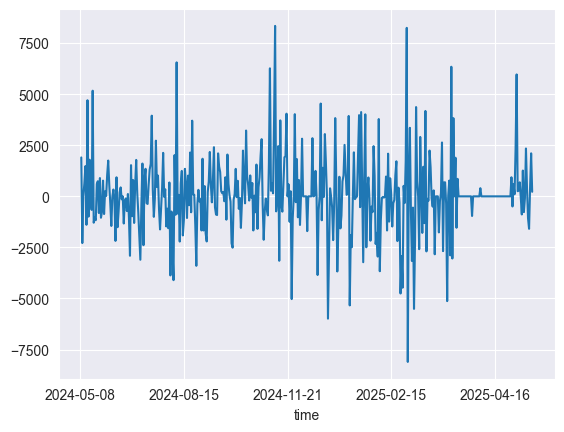

In [24]:
data['gradient'].plot.line()

In [25]:
data['TextType'] = data['link'].apply(lambda x: 'tweet' if x == CONSTANTS.EMPTY_STRING else 'newspaper')

## Traditional Models

1. Decision Tree
2. Random Forest
3. Linear Regression
4. LASSO
5. Ridge Regression

In [26]:
from sklearn.tree import *
from sklearn.ensemble import *
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import *
from sklearn.pipeline import make_pipeline

Cross Validation

In [27]:
def cv_metrics(model, data, yCol='gradient', v=5, trainingColsPath='training_columns.txt'):
    pipeline = make_pipeline(StandardScaler(), model)
    trainingCols = open(trainingColsPath, 'r').readlines()
    trainingCols = [i.strip() for i in trainingCols]
    assert yCol not in trainingCols, f'{yCol} should not be in trainingCols but was found in it'
    myFillNa(data)
    X_train = data.iloc[:int(len(data) * TRAIN_PCT)]
    y_train = data.iloc[:int(len(data) * TRAIN_PCT)][yCol]

    X = pd.get_dummies(X_train[trainingCols])
    y = y_train
    cv_scores = -cross_val_score(pipeline, X, y, cv=10, scoring='neg_root_mean_squared_error')
    cv_scores = pd.Series(cv_scores)
    cv_scores.index += 1
    cv_scores.plot.bar()
    print(f'CV RMSE: {cv_scores.mean()}')
    return cv_scores

CV RMSE: 2236.553797316063


1     1669.179252
2     2044.151594
3     1859.283308
4     1836.938092
5     1400.825273
6     2553.248984
7     2855.464696
8     2608.929850
9     2448.025623
10    3089.491300
dtype: float64

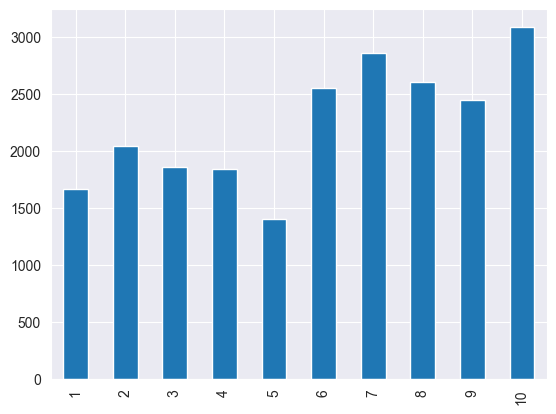

In [28]:
model = DecisionTreeRegressor(max_depth=5)
cv_metrics(model, data)

CV RMSE: 2031.8648081038932


1     1836.575014
2     1405.553949
3     1899.473125
4     1399.934859
5     1311.349097
6     2680.333977
7     2224.758556
8     2500.628834
9     2110.531397
10    2949.509273
dtype: float64

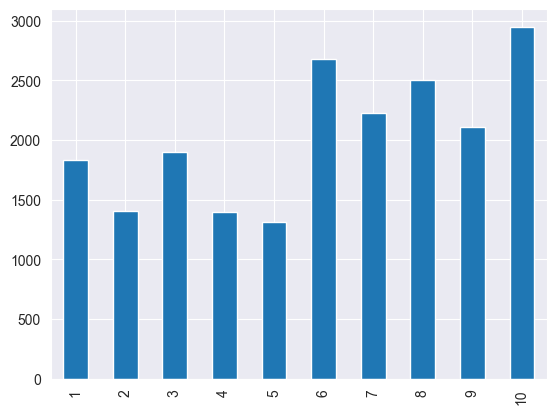

In [29]:
rf = RandomForestRegressor(n_estimators=50, max_depth=50)
cv_metrics(rf, data)

CV RMSE: 1977.2773530439783


1     1568.278514
2     1435.509059
3     2070.088649
4     1491.795364
5     1243.621483
6     2617.548231
7     2046.789429
8     2250.398097
9     2188.886803
10    2859.857901
dtype: float64

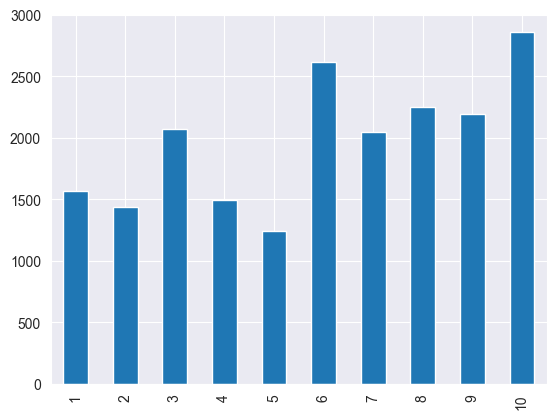

In [30]:
cv_metrics(LinearRegression(), data)

In [31]:
from sklearn.model_selection import GridSearchCV

def hyperparameterTuning(model, tuningDict, yCol='gradient', trainingColsPath='training_columns.txt', v=5):
    trainingCols = open(trainingColsPath, 'r').readlines()
    trainingCols = [i.strip() for i in trainingCols]
    assert yCol not in trainingCols, f'{yCol} should not be in trainingCols but was found in it'
    myFillNa(data)
    X = pd.get_dummies(data[trainingCols])
    y = data[yCol]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    grid_search = GridSearchCV(model, tuningDict, cv=v, scoring='neg_root_mean_squared_error', verbose=1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_params_, -grid_search.best_score_

In [32]:
tuningDict = {
    'max_depth': np.arange(3, 10, 1),
    'min_samples_split': np.arange(2, 4, 1),
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['auto', 'sqrt', 'log2']
}
best_params, best_score = hyperparameterTuning(DecisionTreeRegressor(), tuningDict, v=10)
print(f'Best params: {best_params}')
print(f'Best score: {best_score}')

Fitting 10 folds for each of 168 candidates, totalling 1680 fits
Best params: {'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 3}
Best score: 1919.0239510629503


In [33]:
tuningDict = {
    'max_depth': np.arange(3, 10, 1),
    'n_estimators': np.arange(10, 100, 10),
    'max_features': ['auto', 'sqrt', 'log2']
}
best_params, best_score = hyperparameterTuning(RandomForestRegressor(), tuningDict, v=10)
print(f'Best params: {best_params}')
print(f'Best score: {best_score}')

Fitting 10 folds for each of 189 candidates, totalling 1890 fits
Best params: {'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 30}
Best score: 1923.9570498368291


In [34]:
tuningDict = {
    'alpha': np.arange(0, 50, 1)
}
best_params, best_score = hyperparameterTuning(Lasso(), tuningDict, v=10)
print(f'Best params: {best_params}')
print(f'Best score: {best_score}')

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best params: {'alpha': 0}
Best score: 1951.9268878475516


In [15]:
tuningDict = {
    'alpha': np.arange(0, 195, 1)
}
best_params, best_score = hyperparameterTuning(Ridge(), tuningDict, v=10)
print(f'Best params: {best_params}')
print(f'Best score: {best_score}')

Fitting 10 folds for each of 195 candidates, totalling 1950 fits
Best params: {'alpha': 194}
Best score: 1951.926887256251


So far, the decision tree with {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 3} is the best

## Fit on decision tree

In [16]:
trainingCols = open('training_columns.txt', 'r').readlines()
trainingCols = [i.strip() for i in trainingCols]
myFillNa(data)
X = pd.get_dummies(data[trainingCols])
y = data['gradient']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
finalModel = DecisionTreeRegressor(max_depth=3, max_features='sqrt', min_samples_leaf=4, min_samples_split=3)
finalModel.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3, max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=3)

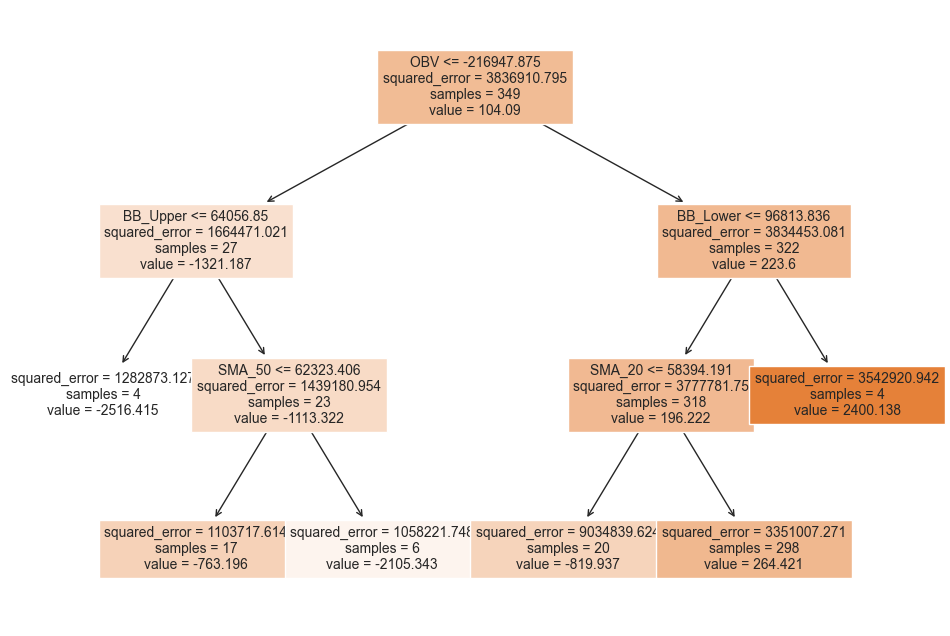

In [18]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Assuming `finalModel` is your trained DecisionTreeRegressor and `X` contains the feature names
plt.figure(figsize=(12, 8))
plot_tree(finalModel, filled=True, feature_names=X.columns, fontsize=10)
plt.show()

<Axes: xlabel='time'>

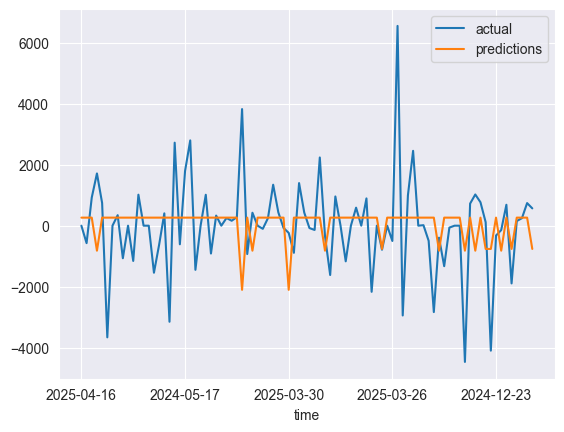

In [19]:
dtPredictions = finalModel.predict(X_test)
pd.DataFrame({
    'actual': y_test,
    'predictions': dtPredictions
}).plot.line()

In [20]:
root_mean_squared_error(y_test, dtPredictions)

1616.6669733175831